Our aim is to reproduce an example from the paper:

[Inferring single-trial neural population dynamics using sequential auto-encoders](https://www.nature.com/articles/s41592-018-0109-9)

We will generate trajectories from a latent Lorentz attractor and apply LFADS to recover the latent dynamic. Instead of using the original code (https://lfads.github.io/lfads-run-manager/) we will use tensorflow 2.

In [1]:
# Maplotlib and numpy 
import numpy as np
import matplotlib.pyplot as plt
# This import registers the 3D projection, but is otherwise unused.
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

# Tensorflow
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

# Lorenz attractor
from Lorenz_Attractor import sample_traj_lorenz

# Sample from latent Lorenz attractor:


In [2]:
traj = sample_traj_lorenz(T = 100,speed_up = 4,initial_offset = 10000)


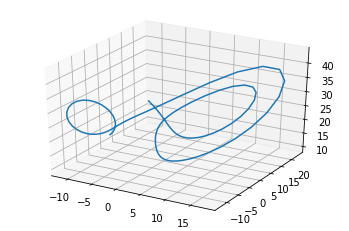

In [3]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot(traj[:,0],traj[:,1],traj[:,2])


In [4]:
# We sample 20 latent trajectories and project them into 50 output neurons using random weights:

Factor = np.random.randn(3,50)

NRep=20
output = np.zeros((NRep,100,50))

for i in range(NRep):
    traj = sample_traj_lorenz(T = 100,speed_up = 4,initial_offset = 10000)
    output[i,:,:] = traj @ Factor
    
output = output.astype('float32')

# Z score output:
output=output.reshape(2000,50)
from scipy import stats
output = stats.zscore(output,axis=0)
output = output.reshape(20,100,50)

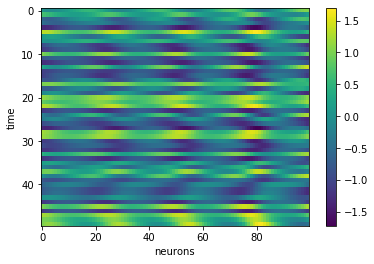

In [5]:
plt.figure()
plt.imshow(output[0,:,:].T,aspect='auto')
plt.xlabel('neurons')
plt.ylabel('time')
plt.colorbar()
plt.show()

In [6]:
# Create Tensorflow Dataset
dataset = tf.data.Dataset.from_tensor_slices((output))
dataset = dataset.shuffle(20, reshuffle_each_iteration=True)

# Autoencoder Model

In [7]:
tf.keras.backend.clear_session()

In [8]:
class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [9]:
class Encoder(tf.keras.layers.Layer):
    """Maps Trajectory to a triplet (z_mean, z_log_var, z)."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 name='encoder',
                 **kwargs):
        super(Encoder, self).__init__(name=name, **kwargs)        
        self.bidir_gru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_gru_unit,return_sequences=False), 
                                                       input_shape=(sequence_length, num_input_neuron))
        self.dense_mean = tf.keras.layers.Dense(latent_dim)
        self.dense_log_var = tf.keras.layers.Dense(latent_dim)
        self.sampling = Sampling()
        
    def call(self, inputs):
        x = self.bidir_gru(inputs)
        z_mean = self.dense_mean(x)
        z_log_var = self.dense_log_var(x)
        z = self.sampling((z_mean, z_log_var))
        return z_mean, z_log_var, z


In [10]:
class Decoder(tf.keras.layers.Layer):
    """Converts z, the encoded digit vector, back into a readable digit."""
    def __init__(self,
                 latent_dim=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 num_factor=3,
                 name='decoder',
                 **kwargs):
        self.sequence_length = sequence_length
        super(Decoder, self).__init__(name=name, **kwargs)
        self.recurrent_decoder = tf.keras.layers.GRU(latent_dim,return_sequences=True)#,use_bias=False)
        self.linear_bottleneck = tf.keras.layers.Dense(num_factor, activation=None)
        self.dense_output = tf.keras.layers.Dense(num_input_neuron, activation=None)
        self.latent_dim=latent_dim
        
    def call(self, inputs):
        
        batch_size = tf.shape(inputs)[0]
        null_input = tf.zeros([batch_size,self.sequence_length,self.latent_dim])
        decoder_output = self.recurrent_decoder(null_input, initial_state=inputs)
        x = self.linear_bottleneck(decoder_output)
        x = self.dense_output(x)
        return x
    

In [11]:
class VariationalAutoEncoder(tf.keras.Model):
    """Combines the encoder and decoder into an end-to-end model for training."""
    def __init__(self,
                 latent_dim=64,
                 num_gru_unit=64,
                 sequence_length=100,
                 num_input_neuron=50,
                 num_factor=3,
                 name='autoencoder',
                 **kwargs):
        super(VariationalAutoEncoder, self).__init__(name=name, **kwargs)
        self.encoder = Encoder(latent_dim=latent_dim,num_gru_unit=num_gru_unit,sequence_length=sequence_length,
                               num_input_neuron=num_input_neuron)
        self.decoder = Decoder(latent_dim=latent_dim, sequence_length=sequence_length,
                              num_input_neuron=num_input_neuron,num_factor=num_factor)
    
    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        reconstructed = self.decoder(z)
        # Add KL divergence regularization loss.
        kl_loss = - 0.5 * tf.reduce_mean(z_log_var - tf.square(z_mean) - tf.exp(z_log_var) + 1)
        self.add_loss(kl_loss)
        return reconstructed

In [12]:
BATCH_SIZE = 20

batched_dataset = dataset.batch(BATCH_SIZE)


In [13]:

vae = VariationalAutoEncoder(latent_dim=64,
                             num_gru_unit=128,
                             sequence_length=100,
                             num_input_neuron=50,
                             num_factor=3)



# Train Model

In [14]:

optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3,clipvalue=200)
mse_loss_fn = tf.keras.losses.MeanSquaredError()
loss_metric = tf.keras.metrics.Mean()


#### Linearly scheduling on the Kullback–Leibler divergence penalty:

We use a linearly increasing schedule on the Kullback–Leibler divergence penalty (as suggested [here](https://arxiv.org/pdf/1511.06349.pdf)) so that the optimization does not quickly (and pathologically) set the Kullback–Leibler divergence to 0


In [15]:
KL_penalty = np.linspace(0,1,10)

In [ ]:
epochs = 2000

for i,kl_ in enumerate(KL_penalty):
    
    # Iterate over epochs.
    for epoch in range(epochs):
        print('Start of epoch %d' % (epoch,))

        # Iterate over the batches of the dataset.
        for step, x_batch_train in enumerate(batched_dataset):
            with tf.GradientTape() as tape:
                reconstructed = vae(x_batch_train)
                # Compute reconstruction loss
                loss = mse_loss_fn(x_batch_train, reconstructed)
                loss += kl_*sum(vae.losses)  # Add KLD regularization loss

            grads = tape.gradient(loss, vae.trainable_weights)
            optimizer.apply_gradients(zip(grads, vae.trainable_weights))
            loss_metric(loss)

            if step % 100 == 0:

                print('step %s: mean loss = %s' % (step, loss_metric.result().numpy()))


Start of epoch 0
step 0: mean loss = 1.0010445
Start of epoch 1
step 0: mean loss = 1.0007929
Start of epoch 2
step 0: mean loss = 1.0007778
Start of epoch 3
step 0: mean loss = 1.0006042
Start of epoch 4
step 0: mean loss = 1.0004917
Start of epoch 5
step 0: mean loss = 1.0004052
Start of epoch 6
step 0: mean loss = 1.0002764
Start of epoch 7
step 0: mean loss = 1.0001249
Start of epoch 8
step 0: mean loss = 0.99999595
Start of epoch 9
step 0: mean loss = 0.99983233
Start of epoch 10
step 0: mean loss = 0.9996512
Start of epoch 11
step 0: mean loss = 0.9994659
Start of epoch 12
step 0: mean loss = 0.99928707
Start of epoch 13
step 0: mean loss = 0.99905205
Start of epoch 14
step 0: mean loss = 0.9988218
Start of epoch 15
step 0: mean loss = 0.99857175
Start of epoch 16
step 0: mean loss = 0.99828476
Start of epoch 17
step 0: mean loss = 0.9979653
Start of epoch 18
step 0: mean loss = 0.9976108
Start of epoch 19
step 0: mean loss = 0.99722195
Start of epoch 20
step 0: mean loss = 0.996

step 0: mean loss = 0.6736796
Start of epoch 171
step 0: mean loss = 0.6720487
Start of epoch 172
step 0: mean loss = 0.6704511
Start of epoch 173
step 0: mean loss = 0.66885614
Start of epoch 174
step 0: mean loss = 0.66722655
Start of epoch 175
step 0: mean loss = 0.6656781
Start of epoch 176
step 0: mean loss = 0.6641403
Start of epoch 177
step 0: mean loss = 0.6625335
Start of epoch 178
step 0: mean loss = 0.66098875
Start of epoch 179
step 0: mean loss = 0.659499
Start of epoch 180
step 0: mean loss = 0.6579198
Start of epoch 181
step 0: mean loss = 0.65642124
Start of epoch 182
step 0: mean loss = 0.65496695
Start of epoch 183
step 0: mean loss = 0.6534279
Start of epoch 184
step 0: mean loss = 0.65193224
Start of epoch 185
step 0: mean loss = 0.6504927
Start of epoch 186
step 0: mean loss = 0.64899313
Start of epoch 187
step 0: mean loss = 0.64750504
Start of epoch 188
step 0: mean loss = 0.6460892
Start of epoch 189
step 0: mean loss = 0.644619
Start of epoch 190
step 0: mean l

step 0: mean loss = 0.4957206
Start of epoch 339
step 0: mean loss = 0.4950038
Start of epoch 340
step 0: mean loss = 0.49426392
Start of epoch 341
step 0: mean loss = 0.4935318
Start of epoch 342
step 0: mean loss = 0.49285454
Start of epoch 343
step 0: mean loss = 0.49217126
Start of epoch 344
step 0: mean loss = 0.49145985
Start of epoch 345
step 0: mean loss = 0.4907345
Start of epoch 346
step 0: mean loss = 0.48999736
Start of epoch 347
step 0: mean loss = 0.4892969
Start of epoch 348
step 0: mean loss = 0.48861757
Start of epoch 349
step 0: mean loss = 0.4879045
Start of epoch 350
step 0: mean loss = 0.48717853
Start of epoch 351
step 0: mean loss = 0.4864805
Start of epoch 352
step 0: mean loss = 0.4858133
Start of epoch 353
step 0: mean loss = 0.4851713
Start of epoch 354
step 0: mean loss = 0.48449793
Start of epoch 355
step 0: mean loss = 0.4838032
Start of epoch 356
step 0: mean loss = 0.4831455
Start of epoch 357
step 0: mean loss = 0.48249868
Start of epoch 358
step 0: mea

step 0: mean loss = 0.40505236
Start of epoch 505
step 0: mean loss = 0.4045753
Start of epoch 506
step 0: mean loss = 0.4040873
Start of epoch 507
step 0: mean loss = 0.4035966
Start of epoch 508
step 0: mean loss = 0.40308106
Start of epoch 509
step 0: mean loss = 0.40259176
Start of epoch 510
step 0: mean loss = 0.40206733
Start of epoch 511
step 0: mean loss = 0.4015534
Start of epoch 512
step 0: mean loss = 0.40103596
Start of epoch 513
step 0: mean loss = 0.40051734
Start of epoch 514
step 0: mean loss = 0.40000248
Start of epoch 515
step 0: mean loss = 0.3994768
Start of epoch 516
step 0: mean loss = 0.39895746
Start of epoch 517
step 0: mean loss = 0.3984266
Start of epoch 518
step 0: mean loss = 0.39790553
Start of epoch 519
step 0: mean loss = 0.39739877
Start of epoch 520
step 0: mean loss = 0.39690158
Start of epoch 521
step 0: mean loss = 0.39641085
Start of epoch 522
step 0: mean loss = 0.39589047
Start of epoch 523
step 0: mean loss = 0.39536884
Start of epoch 524
step 0

step 0: mean loss = 0.3298294
Start of epoch 670
step 0: mean loss = 0.32943356
Start of epoch 671
step 0: mean loss = 0.32903922
Start of epoch 672
step 0: mean loss = 0.32864714
Start of epoch 673
step 0: mean loss = 0.32825744
Start of epoch 674
step 0: mean loss = 0.32787716
Start of epoch 675
step 0: mean loss = 0.32752723
Start of epoch 676
step 0: mean loss = 0.32721806
Start of epoch 677
step 0: mean loss = 0.32690856
Start of epoch 678
step 0: mean loss = 0.32656616
Start of epoch 679
step 0: mean loss = 0.3261936
Start of epoch 680
step 0: mean loss = 0.32581174
Start of epoch 681
step 0: mean loss = 0.32544848
Start of epoch 682
step 0: mean loss = 0.32512182
Start of epoch 683
step 0: mean loss = 0.32479692
Start of epoch 684
step 0: mean loss = 0.3244573
Start of epoch 685
step 0: mean loss = 0.3241
Start of epoch 686
step 0: mean loss = 0.3237246
Start of epoch 687
step 0: mean loss = 0.32336387
Start of epoch 688
step 0: mean loss = 0.32301107
Start of epoch 689
step 0: 

step 0: mean loss = 0.27725822
Start of epoch 836
step 0: mean loss = 0.27698264
Start of epoch 837
step 0: mean loss = 0.27670765
Start of epoch 838
step 0: mean loss = 0.27643353
Start of epoch 839
step 0: mean loss = 0.2761606
Start of epoch 840
step 0: mean loss = 0.2758898
Start of epoch 841
step 0: mean loss = 0.27562425
Start of epoch 842
step 0: mean loss = 0.2753688
Start of epoch 843
step 0: mean loss = 0.27512738
Start of epoch 844
step 0: mean loss = 0.27488372
Start of epoch 845
step 0: mean loss = 0.2746385
Start of epoch 846
step 0: mean loss = 0.27439022
Start of epoch 847
step 0: mean loss = 0.27413622
Start of epoch 848
step 0: mean loss = 0.27387583
Start of epoch 849
step 0: mean loss = 0.27361098
Start of epoch 850
step 0: mean loss = 0.27334204
Start of epoch 851
step 0: mean loss = 0.27307284
Start of epoch 852
step 0: mean loss = 0.27280846
Start of epoch 853
step 0: mean loss = 0.27255127
Start of epoch 854
step 0: mean loss = 0.27230215
Start of epoch 855
step

step 0: mean loss = 0.23829718
Start of epoch 1001
step 0: mean loss = 0.23808363
Start of epoch 1002
step 0: mean loss = 0.23786849
Start of epoch 1003
step 0: mean loss = 0.23765284
Start of epoch 1004
step 0: mean loss = 0.23743612
Start of epoch 1005
step 0: mean loss = 0.23721908
Start of epoch 1006
step 0: mean loss = 0.23700224
Start of epoch 1007
step 0: mean loss = 0.23678595
Start of epoch 1008
step 0: mean loss = 0.23656997
Start of epoch 1009
step 0: mean loss = 0.23635525
Start of epoch 1010
step 0: mean loss = 0.23614272
Start of epoch 1011
step 0: mean loss = 0.23593497
Start of epoch 1012
step 0: mean loss = 0.2357323
Start of epoch 1013
step 0: mean loss = 0.23553383
Start of epoch 1014
step 0: mean loss = 0.2353382
Start of epoch 1015
step 0: mean loss = 0.23514107
Start of epoch 1016
step 0: mean loss = 0.23494343
Start of epoch 1017
step 0: mean loss = 0.23473997
Start of epoch 1018
step 0: mean loss = 0.23453331
Start of epoch 1019
step 0: mean loss = 0.23432413
St

step 0: mean loss = 0.2079049
Start of epoch 1163
step 0: mean loss = 0.2077459
Start of epoch 1164
step 0: mean loss = 0.20758842
Start of epoch 1165
step 0: mean loss = 0.2074327
Start of epoch 1166
step 0: mean loss = 0.20727478
Start of epoch 1167
step 0: mean loss = 0.20711699
Start of epoch 1168
step 0: mean loss = 0.20695916
Start of epoch 1169
step 0: mean loss = 0.20680174
Start of epoch 1170
step 0: mean loss = 0.20664215
Start of epoch 1171
step 0: mean loss = 0.20647912
Start of epoch 1172
step 0: mean loss = 0.20631343
Start of epoch 1173
step 0: mean loss = 0.2061477
Start of epoch 1174
step 0: mean loss = 0.20598538
Start of epoch 1175
step 0: mean loss = 0.20582727
Start of epoch 1176
step 0: mean loss = 0.20567219
Start of epoch 1177
step 0: mean loss = 0.20551771
Start of epoch 1178
step 0: mean loss = 0.20536327
Start of epoch 1179
step 0: mean loss = 0.20520523
Start of epoch 1180
step 0: mean loss = 0.20504493
Start of epoch 1181
step 0: mean loss = 0.20488144
Star

step 0: mean loss = 0.18416212
Start of epoch 1326
step 0: mean loss = 0.18403059
Start of epoch 1327
step 0: mean loss = 0.1838985
Start of epoch 1328
step 0: mean loss = 0.18376647
Start of epoch 1329
step 0: mean loss = 0.18363573
Start of epoch 1330
step 0: mean loss = 0.18350676
Start of epoch 1331
step 0: mean loss = 0.18337871
Start of epoch 1332
step 0: mean loss = 0.18325122
Start of epoch 1333
step 0: mean loss = 0.18312295
Start of epoch 1334
step 0: mean loss = 0.18299466
Start of epoch 1335
step 0: mean loss = 0.18286566
Start of epoch 1336
step 0: mean loss = 0.18273696
Start of epoch 1337
step 0: mean loss = 0.18260866
Start of epoch 1338
step 0: mean loss = 0.18248196
Start of epoch 1339
step 0: mean loss = 0.1823565
Start of epoch 1340
step 0: mean loss = 0.18223137
Start of epoch 1341
step 0: mean loss = 0.18210554
Start of epoch 1342
step 0: mean loss = 0.18198048
Start of epoch 1343
step 0: mean loss = 0.18185441
Start of epoch 1344
step 0: mean loss = 0.18172915
St

step 0: mean loss = 0.16540885
Start of epoch 1488
step 0: mean loss = 0.16530155
Start of epoch 1489
step 0: mean loss = 0.16519497
Start of epoch 1490
step 0: mean loss = 0.16508906
Start of epoch 1491
step 0: mean loss = 0.16498365
Start of epoch 1492
step 0: mean loss = 0.16487871
Start of epoch 1493
step 0: mean loss = 0.16477433
Start of epoch 1494
step 0: mean loss = 0.16467041
Start of epoch 1495
step 0: mean loss = 0.16456728
Start of epoch 1496
step 0: mean loss = 0.16446508
Start of epoch 1497
step 0: mean loss = 0.16436581
Start of epoch 1498
step 0: mean loss = 0.16426682
Start of epoch 1499
step 0: mean loss = 0.16416971
Start of epoch 1500
step 0: mean loss = 0.1640717
Start of epoch 1501
step 0: mean loss = 0.16397266
Start of epoch 1502
step 0: mean loss = 0.16387153
Start of epoch 1503
step 0: mean loss = 0.16376874
Start of epoch 1504
step 0: mean loss = 0.16366486
Start of epoch 1505
step 0: mean loss = 0.16356046
Start of epoch 1506
step 0: mean loss = 0.163456
Sta

step 0: mean loss = 0.15014163
Start of epoch 1651
step 0: mean loss = 0.15005939
Start of epoch 1652
step 0: mean loss = 0.14997827
Start of epoch 1653
step 0: mean loss = 0.14989673
Start of epoch 1654
step 0: mean loss = 0.14981414
Start of epoch 1655
step 0: mean loss = 0.14972988
Start of epoch 1656
step 0: mean loss = 0.1496443
Start of epoch 1657
step 0: mean loss = 0.14955737
Start of epoch 1658
step 0: mean loss = 0.14946984
Start of epoch 1659
step 0: mean loss = 0.14938234
Start of epoch 1660
step 0: mean loss = 0.14929545
Start of epoch 1661
step 0: mean loss = 0.14920978
Start of epoch 1662
step 0: mean loss = 0.14912534
Start of epoch 1663
step 0: mean loss = 0.14904234
Start of epoch 1664
step 0: mean loss = 0.14896064
Start of epoch 1665
step 0: mean loss = 0.14888039
Start of epoch 1666
step 0: mean loss = 0.14879982
Start of epoch 1667
step 0: mean loss = 0.1487189
Start of epoch 1668
step 0: mean loss = 0.1486362
Start of epoch 1669
step 0: mean loss = 0.14855191
Sta

Start of epoch 1813
step 0: mean loss = 0.1374625
Start of epoch 1814
step 0: mean loss = 0.13739578
Start of epoch 1815
step 0: mean loss = 0.13732673
Start of epoch 1816
step 0: mean loss = 0.13725758
Start of epoch 1817
step 0: mean loss = 0.13718948
Start of epoch 1818
step 0: mean loss = 0.13711922
Start of epoch 1819
step 0: mean loss = 0.13704878
Start of epoch 1820
step 0: mean loss = 0.13698076
Start of epoch 1821
step 0: mean loss = 0.13691238
Start of epoch 1822
step 0: mean loss = 0.1368423
Start of epoch 1823
step 0: mean loss = 0.13677196
Start of epoch 1824
step 0: mean loss = 0.13670209
Start of epoch 1825
step 0: mean loss = 0.13663203
Start of epoch 1826
step 0: mean loss = 0.13656123
Start of epoch 1827
step 0: mean loss = 0.13649137
Start of epoch 1828
step 0: mean loss = 0.1364222
Start of epoch 1829
step 0: mean loss = 0.13635181
Start of epoch 1830
step 0: mean loss = 0.13628063
Start of epoch 1831
step 0: mean loss = 0.13620962
Start of epoch 1832
step 0: mean l

step 0: mean loss = 0.1268901
Start of epoch 1976
step 0: mean loss = 0.12682746
Start of epoch 1977
step 0: mean loss = 0.12676483
Start of epoch 1978
step 0: mean loss = 0.12670241
Start of epoch 1979
step 0: mean loss = 0.12664036
Start of epoch 1980
step 0: mean loss = 0.12657885
Start of epoch 1981
step 0: mean loss = 0.12651815
Start of epoch 1982
step 0: mean loss = 0.12645791
Start of epoch 1983
step 0: mean loss = 0.12639815
Start of epoch 1984
step 0: mean loss = 0.12633859
Start of epoch 1985
step 0: mean loss = 0.12627907
Start of epoch 1986
step 0: mean loss = 0.12621929
Start of epoch 1987
step 0: mean loss = 0.12615919
Start of epoch 1988
step 0: mean loss = 0.12609889
Start of epoch 1989
step 0: mean loss = 0.12603869
Start of epoch 1990
step 0: mean loss = 0.12597889
Start of epoch 1991
step 0: mean loss = 0.12592016
Start of epoch 1992
step 0: mean loss = 0.12586242
Start of epoch 1993
step 0: mean loss = 0.12580614
Start of epoch 1994
step 0: mean loss = 0.12574977
S

step 0: mean loss = 0.16742338
Start of epoch 142
step 0: mean loss = 0.16754392
Start of epoch 143
step 0: mean loss = 0.1676608
Start of epoch 144
step 0: mean loss = 0.1677838
Start of epoch 145
step 0: mean loss = 0.1678968
Start of epoch 146
step 0: mean loss = 0.16801971
Start of epoch 147
step 0: mean loss = 0.16817103
Start of epoch 148
step 0: mean loss = 0.1682947
Start of epoch 149
step 0: mean loss = 0.16844563
Start of epoch 150
step 0: mean loss = 0.16861981
Start of epoch 151
step 0: mean loss = 0.16882801
Start of epoch 152
step 0: mean loss = 0.16898184
Start of epoch 153
step 0: mean loss = 0.16915819
Start of epoch 154
step 0: mean loss = 0.16930665
Start of epoch 155
step 0: mean loss = 0.16946901
Start of epoch 156
step 0: mean loss = 0.16961913
Start of epoch 157
step 0: mean loss = 0.16977234
Start of epoch 158
step 0: mean loss = 0.16991627
Start of epoch 159
step 0: mean loss = 0.17006639
Start of epoch 160
step 0: mean loss = 0.17020561
Start of epoch 161
step

step 0: mean loss = 0.18243016
Start of epoch 308
step 0: mean loss = 0.18253788
Start of epoch 309
step 0: mean loss = 0.18263972
Start of epoch 310
step 0: mean loss = 0.18277758
Start of epoch 311
step 0: mean loss = 0.18291894
Start of epoch 312
step 0: mean loss = 0.1830483
Start of epoch 313
step 0: mean loss = 0.1831747
Start of epoch 314
step 0: mean loss = 0.18336338
Start of epoch 315
step 0: mean loss = 0.18348718
Start of epoch 316
step 0: mean loss = 0.18360735
Start of epoch 317
step 0: mean loss = 0.18373978
Start of epoch 318
step 0: mean loss = 0.18384093
Start of epoch 319
step 0: mean loss = 0.18394618
Start of epoch 320
step 0: mean loss = 0.18406206
Start of epoch 321
step 0: mean loss = 0.1842084
Start of epoch 322
step 0: mean loss = 0.18433884
Start of epoch 323
step 0: mean loss = 0.18444262
Start of epoch 324
step 0: mean loss = 0.1845324
Start of epoch 325
step 0: mean loss = 0.18462636
Start of epoch 326
step 0: mean loss = 0.18473262
Start of epoch 327
step

step 0: mean loss = 0.21163793
Start of epoch 474
step 0: mean loss = 0.21172501
Start of epoch 475
step 0: mean loss = 0.21180858
Start of epoch 476
step 0: mean loss = 0.21188323
Start of epoch 477
step 0: mean loss = 0.21196702
Start of epoch 478
step 0: mean loss = 0.21203776
Start of epoch 479
step 0: mean loss = 0.21211912
Start of epoch 480
step 0: mean loss = 0.2121953
Start of epoch 481
step 0: mean loss = 0.21227956
Start of epoch 482
step 0: mean loss = 0.2123536
Start of epoch 483
step 0: mean loss = 0.21243718
Start of epoch 484
step 0: mean loss = 0.21250384
Start of epoch 485
step 0: mean loss = 0.21258184
Start of epoch 486
step 0: mean loss = 0.21264516
Start of epoch 487
step 0: mean loss = 0.21272263
Start of epoch 488
step 0: mean loss = 0.21279868
Start of epoch 489
step 0: mean loss = 0.21290025
Start of epoch 490
step 0: mean loss = 0.21296588
Start of epoch 491
step 0: mean loss = 0.21303816
Start of epoch 492
step 0: mean loss = 0.21310997
Start of epoch 493
st

step 0: mean loss = 0.22958224
Start of epoch 638
step 0: mean loss = 0.22965117
Start of epoch 639
step 0: mean loss = 0.22972798
Start of epoch 640
step 0: mean loss = 0.22978407
Start of epoch 641
step 0: mean loss = 0.2298584
Start of epoch 642
step 0: mean loss = 0.22991648
Start of epoch 643
step 0: mean loss = 0.2299647
Start of epoch 644
step 0: mean loss = 0.2300463
Start of epoch 645
step 0: mean loss = 0.23010063
Start of epoch 646
step 0: mean loss = 0.23016135
Start of epoch 647
step 0: mean loss = 0.23020668
Start of epoch 648
step 0: mean loss = 0.2302492
Start of epoch 649
step 0: mean loss = 0.23029076
Start of epoch 650
step 0: mean loss = 0.23033063
Start of epoch 651
step 0: mean loss = 0.23036863
Start of epoch 652
step 0: mean loss = 0.23043407
Start of epoch 653
step 0: mean loss = 0.2304865
Start of epoch 654
step 0: mean loss = 0.23053965
Start of epoch 655
step 0: mean loss = 0.23059048
Start of epoch 656
step 0: mean loss = 0.23062997
Start of epoch 657
step 

step 0: mean loss = 0.23122261
Start of epoch 804
step 0: mean loss = 0.2312154
Start of epoch 805
step 0: mean loss = 0.2312199
Start of epoch 806
step 0: mean loss = 0.23124668
Start of epoch 807
step 0: mean loss = 0.23124056
Start of epoch 808
step 0: mean loss = 0.23125385
Start of epoch 809
step 0: mean loss = 0.23125575
Start of epoch 810
step 0: mean loss = 0.23127252
Start of epoch 811
step 0: mean loss = 0.23126557
Start of epoch 812
step 0: mean loss = 0.23126002
Start of epoch 813
step 0: mean loss = 0.23125687
Start of epoch 814
step 0: mean loss = 0.23124254
Start of epoch 815
step 0: mean loss = 0.23123883
Start of epoch 816
step 0: mean loss = 0.23123072
Start of epoch 817
step 0: mean loss = 0.23121727
Start of epoch 818
step 0: mean loss = 0.23120628
Start of epoch 819
step 0: mean loss = 0.23119934
Start of epoch 820
step 0: mean loss = 0.23118494
Start of epoch 821
step 0: mean loss = 0.23116702
Start of epoch 822
step 0: mean loss = 0.23114929
Start of epoch 823
st

step 0: mean loss = 0.23019013
Start of epoch 970
step 0: mean loss = 0.23016891
Start of epoch 971
step 0: mean loss = 0.23014924
Start of epoch 972
step 0: mean loss = 0.2301237
Start of epoch 973
step 0: mean loss = 0.23010059
Start of epoch 974
step 0: mean loss = 0.23008572
Start of epoch 975
step 0: mean loss = 0.23006739
Start of epoch 976
step 0: mean loss = 0.23004712
Start of epoch 977
step 0: mean loss = 0.23002306
Start of epoch 978
step 0: mean loss = 0.23000619
Start of epoch 979
step 0: mean loss = 0.22998472
Start of epoch 980
step 0: mean loss = 0.22995919
Start of epoch 981
step 0: mean loss = 0.22993422
Start of epoch 982
step 0: mean loss = 0.22990581
Start of epoch 983
step 0: mean loss = 0.22987732
Start of epoch 984
step 0: mean loss = 0.22984819
Start of epoch 985
step 0: mean loss = 0.229822
Start of epoch 986
step 0: mean loss = 0.2297988
Start of epoch 987
step 0: mean loss = 0.22977075
Start of epoch 988
step 0: mean loss = 0.22974326
Start of epoch 989
step

step 0: mean loss = 0.22785908
Start of epoch 1133
step 0: mean loss = 0.22783224
Start of epoch 1134
step 0: mean loss = 0.22781044
Start of epoch 1135
step 0: mean loss = 0.22778647
Start of epoch 1136
step 0: mean loss = 0.22776362
Start of epoch 1137
step 0: mean loss = 0.2277403
Start of epoch 1138
step 0: mean loss = 0.22771753
Start of epoch 1139
step 0: mean loss = 0.22769108
Start of epoch 1140
step 0: mean loss = 0.22766414
Start of epoch 1141
step 0: mean loss = 0.22764872
Start of epoch 1142
step 0: mean loss = 0.22761956
Start of epoch 1143
step 0: mean loss = 0.22759195
Start of epoch 1144
step 0: mean loss = 0.22756425
Start of epoch 1145
step 0: mean loss = 0.22753565
Start of epoch 1146
step 0: mean loss = 0.22750817
Start of epoch 1147
step 0: mean loss = 0.22747959
Start of epoch 1148
step 0: mean loss = 0.22745278
Start of epoch 1149
step 0: mean loss = 0.22742802
Start of epoch 1150
step 0: mean loss = 0.22740151
Start of epoch 1151
step 0: mean loss = 0.22737455
S

step 0: mean loss = 0.22370201
Start of epoch 1295
step 0: mean loss = 0.22367705
Start of epoch 1296
step 0: mean loss = 0.22365196
Start of epoch 1297
step 0: mean loss = 0.22362447
Start of epoch 1298
step 0: mean loss = 0.22360273
Start of epoch 1299
step 0: mean loss = 0.22357674
Start of epoch 1300
step 0: mean loss = 0.22355318
Start of epoch 1301
step 0: mean loss = 0.22352704
Start of epoch 1302
step 0: mean loss = 0.22350337
Start of epoch 1303
step 0: mean loss = 0.22347802
Start of epoch 1304
step 0: mean loss = 0.22344984
Start of epoch 1305
step 0: mean loss = 0.22342783
Start of epoch 1306
step 0: mean loss = 0.22339901
Start of epoch 1307
step 0: mean loss = 0.22337398
Start of epoch 1308
step 0: mean loss = 0.22334695
Start of epoch 1309
step 0: mean loss = 0.22331645
Start of epoch 1310
step 0: mean loss = 0.22329569
Start of epoch 1311
step 0: mean loss = 0.22326684
Start of epoch 1312
step 0: mean loss = 0.22323799
Start of epoch 1313
step 0: mean loss = 0.2232095
S

step 0: mean loss = 0.2199025
Start of epoch 1457
step 0: mean loss = 0.21989585
Start of epoch 1458
step 0: mean loss = 0.21989919
Start of epoch 1459
step 0: mean loss = 0.21989498
Start of epoch 1460
step 0: mean loss = 0.21988897
Start of epoch 1461
step 0: mean loss = 0.21988744
Start of epoch 1462
step 0: mean loss = 0.21988347
Start of epoch 1463
step 0: mean loss = 0.21989343
Start of epoch 1464
step 0: mean loss = 0.21990328
Start of epoch 1465
step 0: mean loss = 0.21992984
Start of epoch 1466
step 0: mean loss = 0.22004962
Start of epoch 1467
step 0: mean loss = 0.22021621
Start of epoch 1468
step 0: mean loss = 0.22039385
Start of epoch 1469
step 0: mean loss = 0.22058521
Start of epoch 1470
step 0: mean loss = 0.22078162
Start of epoch 1471
step 0: mean loss = 0.22095855
Start of epoch 1472
step 0: mean loss = 0.22113205
Start of epoch 1473
step 0: mean loss = 0.22131436
Start of epoch 1474
step 0: mean loss = 0.22149071
Start of epoch 1475
step 0: mean loss = 0.22167677
S

step 0: mean loss = 0.23281616
Start of epoch 1619
step 0: mean loss = 0.2328802
Start of epoch 1620
step 0: mean loss = 0.23294127
Start of epoch 1621
step 0: mean loss = 0.23300114
Start of epoch 1622
step 0: mean loss = 0.23305665
Start of epoch 1623
step 0: mean loss = 0.23311089
Start of epoch 1624
step 0: mean loss = 0.23316959
Start of epoch 1625
step 0: mean loss = 0.23322545
Start of epoch 1626
step 0: mean loss = 0.23327756
Start of epoch 1627
step 0: mean loss = 0.2333366
Start of epoch 1628
step 0: mean loss = 0.23339167
Start of epoch 1629
step 0: mean loss = 0.23344518
Start of epoch 1630
step 0: mean loss = 0.23349687
Start of epoch 1631
step 0: mean loss = 0.23354638
Start of epoch 1632
step 0: mean loss = 0.23359577
Start of epoch 1633
step 0: mean loss = 0.23364785
Start of epoch 1634
step 0: mean loss = 0.23369753
Start of epoch 1635
step 0: mean loss = 0.23374477
Start of epoch 1636
step 0: mean loss = 0.23379393
Start of epoch 1637
step 0: mean loss = 0.23384432
St

step 0: mean loss = 0.24168028
Start of epoch 1781
step 0: mean loss = 0.24179207
Start of epoch 1782
step 0: mean loss = 0.24190255
Start of epoch 1783
step 0: mean loss = 0.24200726
Start of epoch 1784
step 0: mean loss = 0.2421101
Start of epoch 1785
step 0: mean loss = 0.24222112
Start of epoch 1786
step 0: mean loss = 0.24232589
Start of epoch 1787
step 0: mean loss = 0.24241911
Start of epoch 1788
step 0: mean loss = 0.24251977
Start of epoch 1789
step 0: mean loss = 0.24261777
Start of epoch 1790
step 0: mean loss = 0.24270983
Start of epoch 1791
step 0: mean loss = 0.24279779
Start of epoch 1792
step 0: mean loss = 0.24289192
Start of epoch 1793
step 0: mean loss = 0.24298331
Start of epoch 1794
step 0: mean loss = 0.2430737
Start of epoch 1795
step 0: mean loss = 0.24316955
Start of epoch 1796
step 0: mean loss = 0.24325629
Start of epoch 1797
step 0: mean loss = 0.24333468
Start of epoch 1798
step 0: mean loss = 0.24341238
Start of epoch 1799
step 0: mean loss = 0.24348614
St

step 0: mean loss = 0.25993058
Start of epoch 1944
step 0: mean loss = 0.2601174
Start of epoch 1945
step 0: mean loss = 0.26030046
Start of epoch 1946
step 0: mean loss = 0.26047593
Start of epoch 1947
step 0: mean loss = 0.26064247
Start of epoch 1948
step 0: mean loss = 0.26080415
Start of epoch 1949
step 0: mean loss = 0.26096207
Start of epoch 1950
step 0: mean loss = 0.2611118
Start of epoch 1951
step 0: mean loss = 0.26125467
Start of epoch 1952
step 0: mean loss = 0.2614066
Start of epoch 1953
step 0: mean loss = 0.261542
Start of epoch 1954
step 0: mean loss = 0.26167852
Start of epoch 1955
step 0: mean loss = 0.26181725
Start of epoch 1956
step 0: mean loss = 0.26195517
Start of epoch 1957
step 0: mean loss = 0.26208538
Start of epoch 1958
step 0: mean loss = 0.2622236
Start of epoch 1959
step 0: mean loss = 0.2623535
Start of epoch 1960
step 0: mean loss = 0.26247856
Start of epoch 1961
step 0: mean loss = 0.26260316
Start of epoch 1962
step 0: mean loss = 0.2627203
Start of

step 0: mean loss = 0.28523633
Start of epoch 112
step 0: mean loss = 0.28552443
Start of epoch 113
step 0: mean loss = 0.28580838
Start of epoch 114
step 0: mean loss = 0.2860809
Start of epoch 115
step 0: mean loss = 0.28634802
Start of epoch 116
step 0: mean loss = 0.28659827
Start of epoch 117
step 0: mean loss = 0.28684244
Start of epoch 118
step 0: mean loss = 0.28708473
Start of epoch 119
step 0: mean loss = 0.2873239
Start of epoch 120
step 0: mean loss = 0.2875473
Start of epoch 121
step 0: mean loss = 0.28776664
Start of epoch 122
step 0: mean loss = 0.2879846
Start of epoch 123
step 0: mean loss = 0.28819177
Start of epoch 124
step 0: mean loss = 0.2883996
Start of epoch 125
step 0: mean loss = 0.2886018
Start of epoch 126
step 0: mean loss = 0.28879252
Start of epoch 127
step 0: mean loss = 0.28898445
Start of epoch 128
step 0: mean loss = 0.28916433
Start of epoch 129
step 0: mean loss = 0.2893368
Start of epoch 130
step 0: mean loss = 0.2895154
Start of epoch 131
step 0: 

step 0: mean loss = 0.3249807
Start of epoch 278
step 0: mean loss = 0.3251282
Start of epoch 279
step 0: mean loss = 0.32527342
Start of epoch 280
step 0: mean loss = 0.3254218
Start of epoch 281
step 0: mean loss = 0.32556522
Start of epoch 282
step 0: mean loss = 0.32571203
Start of epoch 283
step 0: mean loss = 0.32585832
Start of epoch 284
step 0: mean loss = 0.32600072
Start of epoch 285
step 0: mean loss = 0.3261397
Start of epoch 286
step 0: mean loss = 0.32627973
Start of epoch 287
step 0: mean loss = 0.3264167
Start of epoch 288
step 0: mean loss = 0.32655615
Start of epoch 289
step 0: mean loss = 0.32669157
Start of epoch 290
step 0: mean loss = 0.3268281
Start of epoch 291
step 0: mean loss = 0.32696837
Start of epoch 292
step 0: mean loss = 0.3271049
Start of epoch 293
step 0: mean loss = 0.32723895
Start of epoch 294
step 0: mean loss = 0.32736942
Start of epoch 295
step 0: mean loss = 0.32750392
Start of epoch 296
step 0: mean loss = 0.32763672
Start of epoch 297
step 0:

step 0: mean loss = 0.3437342
Start of epoch 444
step 0: mean loss = 0.3438182
Start of epoch 445
step 0: mean loss = 0.3439024
Start of epoch 446
step 0: mean loss = 0.34398133
Start of epoch 447
step 0: mean loss = 0.34406325
Start of epoch 448
step 0: mean loss = 0.34414682
Start of epoch 449
step 0: mean loss = 0.3442521
Start of epoch 450
step 0: mean loss = 0.34439844
Start of epoch 451
step 0: mean loss = 0.34457806
Start of epoch 452
step 0: mean loss = 0.34483054
Start of epoch 453
step 0: mean loss = 0.3451247
Start of epoch 454
step 0: mean loss = 0.34676105
Start of epoch 455
step 0: mean loss = 0.34715325
Start of epoch 456
step 0: mean loss = 0.34762666
Start of epoch 457
step 0: mean loss = 0.3481726
Start of epoch 458
step 0: mean loss = 0.34880984
Start of epoch 459
step 0: mean loss = 0.3492071
Start of epoch 460
step 0: mean loss = 0.34958035
Start of epoch 461
step 0: mean loss = 0.3499081
Start of epoch 462
step 0: mean loss = 0.35023433
Start of epoch 463
step 0: 

step 0: mean loss = 0.36865187
Start of epoch 609
step 0: mean loss = 0.36872512
Start of epoch 610
step 0: mean loss = 0.36879373
Start of epoch 611
step 0: mean loss = 0.36886963
Start of epoch 612
step 0: mean loss = 0.3689546
Start of epoch 613
step 0: mean loss = 0.36903375
Start of epoch 614
step 0: mean loss = 0.36911047
Start of epoch 615
step 0: mean loss = 0.36919674
Start of epoch 616
step 0: mean loss = 0.36927712
Start of epoch 617
step 0: mean loss = 0.3693513
Start of epoch 618
step 0: mean loss = 0.36942634
Start of epoch 619
step 0: mean loss = 0.36949968
Start of epoch 620
step 0: mean loss = 0.369576
Start of epoch 621
step 0: mean loss = 0.3696478
Start of epoch 622
step 0: mean loss = 0.36971182
Start of epoch 623
step 0: mean loss = 0.36977512
Start of epoch 624
step 0: mean loss = 0.3698488
Start of epoch 625
step 0: mean loss = 0.36990878
Start of epoch 626
step 0: mean loss = 0.36996952
Start of epoch 627
step 0: mean loss = 0.37003052
Start of epoch 628
step 0

step 0: mean loss = 0.37830415
Start of epoch 775
step 0: mean loss = 0.37836054
Start of epoch 776
step 0: mean loss = 0.37841746
Start of epoch 777
step 0: mean loss = 0.3784759
Start of epoch 778
step 0: mean loss = 0.37853366
Start of epoch 779
step 0: mean loss = 0.37858462
Start of epoch 780
step 0: mean loss = 0.37864742
Start of epoch 781
step 0: mean loss = 0.37870046
Start of epoch 782
step 0: mean loss = 0.3787476
Start of epoch 783
step 0: mean loss = 0.3787937
Start of epoch 784
step 0: mean loss = 0.37884253
Start of epoch 785
step 0: mean loss = 0.37888947
Start of epoch 786
step 0: mean loss = 0.37893513
Start of epoch 787
step 0: mean loss = 0.37898052
Start of epoch 788
step 0: mean loss = 0.3790274
Start of epoch 789
step 0: mean loss = 0.3790712
Start of epoch 790
step 0: mean loss = 0.37911177
Start of epoch 791
step 0: mean loss = 0.3791504
Start of epoch 792
step 0: mean loss = 0.37918922
Start of epoch 793
step 0: mean loss = 0.37922516
Start of epoch 794
step 0

step 0: mean loss = 0.38684136
Start of epoch 941
step 0: mean loss = 0.38708183
Start of epoch 942
step 0: mean loss = 0.38734704
Start of epoch 943
step 0: mean loss = 0.38761866
Start of epoch 944
step 0: mean loss = 0.3878885
Start of epoch 945
step 0: mean loss = 0.38817635
Start of epoch 946
step 0: mean loss = 0.3884555
Start of epoch 947
step 0: mean loss = 0.38874072
Start of epoch 948
step 0: mean loss = 0.38903874
Start of epoch 949
step 0: mean loss = 0.38931906
Start of epoch 950
step 0: mean loss = 0.38957983
Start of epoch 951
step 0: mean loss = 0.38983846
Start of epoch 952
step 0: mean loss = 0.39009428
Start of epoch 953
step 0: mean loss = 0.39034447
Start of epoch 954
step 0: mean loss = 0.39059338
Start of epoch 955
step 0: mean loss = 0.390839
Start of epoch 956
step 0: mean loss = 0.39108884
Start of epoch 957
step 0: mean loss = 0.39131734
Start of epoch 958
step 0: mean loss = 0.3915513
Start of epoch 959
step 0: mean loss = 0.3917781
Start of epoch 960
step 0

step 0: mean loss = 0.40960604
Start of epoch 1104
step 0: mean loss = 0.4097706
Start of epoch 1105
step 0: mean loss = 0.40993205
Start of epoch 1106
step 0: mean loss = 0.41008615
Start of epoch 1107
step 0: mean loss = 0.4102354
Start of epoch 1108
step 0: mean loss = 0.41038907
Start of epoch 1109
step 0: mean loss = 0.41052887
Start of epoch 1110
step 0: mean loss = 0.41066805
Start of epoch 1111
step 0: mean loss = 0.41080642
Start of epoch 1112
step 0: mean loss = 0.41093633
Start of epoch 1113
step 0: mean loss = 0.4110603
Start of epoch 1114
step 0: mean loss = 0.4111782
Start of epoch 1115
step 0: mean loss = 0.41129586
Start of epoch 1116
step 0: mean loss = 0.41141096
Start of epoch 1117
step 0: mean loss = 0.41152033
Start of epoch 1118
step 0: mean loss = 0.41163093
Start of epoch 1119
step 0: mean loss = 0.41175
Start of epoch 1120
step 0: mean loss = 0.41186398
Start of epoch 1121
step 0: mean loss = 0.41198105
Start of epoch 1122
step 0: mean loss = 0.412091
Start of 

step 0: mean loss = 0.41824335
Start of epoch 1267
step 0: mean loss = 0.41825637
Start of epoch 1268
step 0: mean loss = 0.41826975
Start of epoch 1269
step 0: mean loss = 0.41828322
Start of epoch 1270
step 0: mean loss = 0.4182957
Start of epoch 1271
step 0: mean loss = 0.41831082
Start of epoch 1272
step 0: mean loss = 0.4183239
Start of epoch 1273
step 0: mean loss = 0.41834092
Start of epoch 1274
step 0: mean loss = 0.4183549
Start of epoch 1275
step 0: mean loss = 0.41836616
Start of epoch 1276
step 0: mean loss = 0.41837746
Start of epoch 1277
step 0: mean loss = 0.4183915
Start of epoch 1278
step 0: mean loss = 0.4184034
Start of epoch 1279
step 0: mean loss = 0.41841254
Start of epoch 1280
step 0: mean loss = 0.41842425
Start of epoch 1281
step 0: mean loss = 0.41843337
Start of epoch 1282
step 0: mean loss = 0.41844547
Start of epoch 1283
step 0: mean loss = 0.41845796
Start of epoch 1284
step 0: mean loss = 0.41847095
Start of epoch 1285
step 0: mean loss = 0.41848987
Start

# Evaluate Quality of reconstruction 

In [ ]:
for x in batched_dataset.take(1):
    for i in range(x.shape[0]):
        plt.figure()
        plt.plot(x[i,:,0],'k')
        for j in range(3):
            x_hat = vae(x)
            plt.plot(x_hat[i,:,0])
